# Part 1

In [ ]:
# Author: Xiaopeng Pan
# ID: 1129446
# Purpose: Assignment 2
# Date: Feb 26, 2021

# import basic packages
import numpy as np
import matplotlib.pyplot as plt
import os                   # to list the images
import pickle               # to save and load pickle files
import random
import time

# import sklearn packages 
from sklearn.model_selection import train_test_split      # to split the whole dataset to train and test
from sklearn.model_selection import StratifiedKFold       # to train the CNN model by cross validation

# to evaluate the performance
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix

# import keras package to create the CNN model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from keras import optimizers

import warnings   # to disable warning
warnings.filterwarnings('ignore')     

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


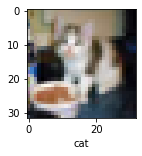

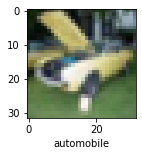

In [ ]:
# method to plot an image
def plot_img(X, y, classes):
  plt.figure(figsize = (15,2))
  plt.imshow(X)
  plt.xlabel(classes[int(y[0].item())])
  plt.show()

classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

# test the method
# from train set
img_path = r'/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/CIFAR10/cifar/TRAINSET/cat/TrainImage_1000.bmp'
img = image.load_img(img_path, target_size=(32, 32))
img_value = image.img_to_array(img)
img_value = np.expand_dims(img_value, axis=0)
img_label = np.array([3])

plot_img(img_value[0].astype(np.uint8),img_label,classes)

# from test set
img_path = r'/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/CIFAR10/cifar/TESTSET/automobile/TestImage_1000.bmp'
img = image.load_img(img_path, target_size=(32, 32))
img_value = image.img_to_array(img)
img_value = np.expand_dims(img_value, axis=0)
img_label = np.array([1])

plot_img(img_value[0].astype(np.uint8),img_label,classes)

In [ ]:
def build_dataset(data_path,X,y):
  if "TRAIN" in data_path:
    if os.path.exists("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy") and \
       os.path.exists("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy"):
      print("Train sets exist!")
      return
  elif "TEST" in data_path:
    if os.path.exists("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy") and \
       os.path.exists("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy"):
      print("Test sets exist!")
      return

  file_index = 0
  file_list = os.listdir(data_path)
  
  classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

  # read image data
  for c in file_list:
    data_path_2 = data_path + "/" + c
    file_list_2 = os.listdir(data_path_2)
    print("class '",c,"' in process...")
    for file_name in file_list_2:
      img_path = data_path_2 + "/" + file_name
      img = image.load_img(img_path, target_size=(32, 32))
      img_value = image.img_to_array(img)
      img_value = np.expand_dims(img_value, axis=0)
      img_value = img_value.astype(np.uint8)
      img_label = np.array([classes.index(c)])
      
      X[file_index] = img_value # assign image attribute values to X array
      y[file_index] = img_label

      if file_list_2.index(file_name) % 1000 == 0 or (file_list_2.index(file_name)+1) % 1000 == 0:
        plot_img(img_value[0],img_label,classes)
      if file_list_2.index(file_name) % 200 == 0:
        print("%5d"%(file_list_2.index(file_name)+1),end="")
      elif (file_list_2.index(file_name) +1) % 200 == 0:
        print("%5d"%(file_list_2.index(file_name)+1))
      else:
        print(".",end="")
      file_index = file_index + 1
    print(file_index,"images have been processed.")

  
  # save the extracted data
  if "TRAIN" in data_path:
    np.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy",X)
    print("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy saved.")
    np.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy",y)
    print("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy saved.")
  elif "TEST" in data_path:
    np.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy",X)
    print("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy saved.")
    np.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy",y)
    print("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy saved.")


In [ ]:
# generate the dataset to be processed
X_train = np.zeros((50000,32,32,3),dtype=np.uint8)
y_train = np.zeros((50000,1),dtype=np.uint8)
X_test = np.zeros((10000,32,32,3),dtype=np.uint8)
y_test = np.zeros((10000,1),dtype=np.uint8)

print("Building the train set")
print("-"*80)
data_path = r'/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/CIFAR10/cifar/TRAINSET'
build_dataset(data_path,X_train,y_train)
print("Building the test set")
print("-"*80)
data_path = r'/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/CIFAR10/cifar/TESTSET'
build_dataset(data_path,X_test,y_test)


Building the train set
--------------------------------------------------------------------------------
Train sets exist!
Building the test set
--------------------------------------------------------------------------------
Test sets exist!


train feature size: (50000, 32, 32, 3)
train label size: (50000, 1)
test feature size: (10000, 32, 32, 3)
test label size: (10000, 1)

Sanity test for train set:


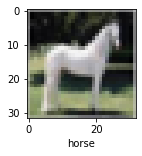

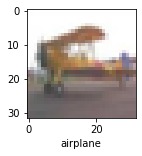

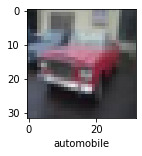

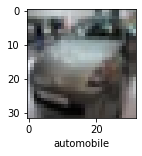

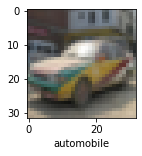

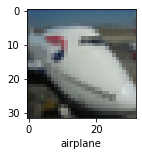

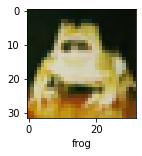

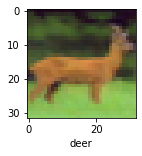

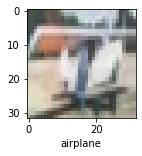

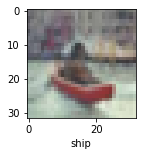


Sanity test for test set:


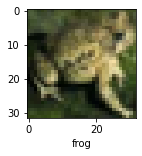

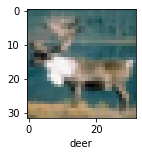

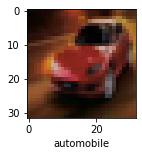

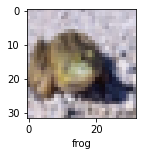

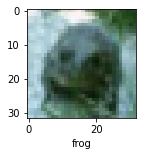

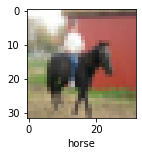

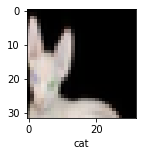

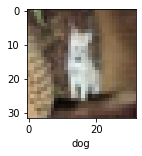

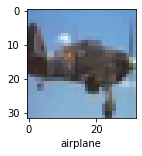

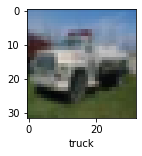

In [ ]:
# sanity test for the images
# load the saved datasets
X_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy")
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy")
X_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy")
y_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy")

print("train feature size:", X_train.shape)
print("train label size:", y_train.shape)
print("test feature size:", X_test.shape)
print("test label size:", y_test.shape)

# train set
import random
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

print()
print("Sanity test for train set:")
for i in range(10):
  idx = random.randint(0,X_train.shape[0]-1)
  img_value = X_train[idx]
  img_label = y_train[idx]
  plot_img(img_value,img_label,classes)
plt.show()

# test set

print()
print("Sanity test for test set:")
for i in range(10):
  idx = random.randint(0,X_test.shape[0]-1)
  img_value = X_test[idx]
  img_label = y_test[idx]
  plot_img(img_value,img_label,classes)
plt.show()

In [ ]:
# shuffle the train dataset
def shuffle_by_row(X,y):
  import random
  row_num = []

  X_ = np.zeros_like(X)
  y_ = np.zeros_like(y)

  r_idx = 0
  while len(row_num)<y.shape[0]:
    r_n = random.randint(0,y.shape[0]-1)
    if r_n not in row_num:
      row_num.append(r_n)
      X_[r_idx] = X[r_n]
      y_[r_idx] = y[r_n]
      r_idx += 1
  
  return X_, y_

In [ ]:
# plot loss and accuracies
def plot_loss_acc(acc_tr,acc_va,acc_te,loss,fig_w,fig_h):
  ep = [i for i in range(1,len(acc_tr)+1,1)]
  
  fig, ax1 = plt.subplots(figsize=(fig_w, fig_h))
  ax1.plot(ep, loss, color='tab:red')
  ax1.set_title('Loss and Accuracy')
  ax1.set_xticks(ep)
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.tick_params(axis='y')

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  ax2.plot(ep, acc_tr)
  ax2.plot(ep, acc_va)
  ax2.plot(ep, acc_te)
  ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
  ax2.legend(['training', 'validation', 'testing'], loc='upper right')
  ax2.tick_params(axis='y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()

In [ ]:
# get the model
def getModel(activation_function, img_rows, img_cols, channel_number):
    model = Sequential()
    
    # 2 convolutional layers with names 'conv1', 'conv2'
    model.add(Conv2D(32, kernel_size = (5, 5), activation=activation_function, input_shape=(img_rows, img_cols, channel_number), name='conv1'))
    model.add(Conv2D(32, kernel_size = (5, 5), activation=activation_function, name='conv2'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # 2 convolutional layers with names 'conv3', 'conv4'
    model.add(Conv2D(64, kernel_size=(3,3), activation=activation_function, name='conv3'))
    model.add(Conv2D(64, kernel_size=(3,3), activation=activation_function, name='conv4'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # 1 convolutional layers with name 'conv5'
    model.add(Conv2D(128, kernel_size=(3,3), activation=activation_function, name='conv5'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    # 3 4 dense layers with names 'dens1', 'dens2', 'dens3', 'dens4'
    model.add(Flatten())
    model.add(Dense(128, activation=activation_function, name='dens1'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation=activation_function, name='dens2'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation=activation_function, name='dens3'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation = 'softmax', name='dens4'))
    model.summary()
    return model

In [ ]:
# generate and save the dataset to be processed
X_train = np.zeros((50000,32,32,3),dtype=np.uint8)
y_train = np.zeros((50000,1),dtype=np.uint8)
X_test = np.zeros((10000,32,32,3),dtype=np.uint8)
y_test = np.zeros((10000,1),dtype=np.uint8)

data_path = r'/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/CIFAR10/cifar/TRAINSET'
build_dataset(data_path,X_train,y_train)
data_path = r'/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/CIFAR10/cifar/TESTSET'
build_dataset(data_path,X_test,y_test)


Train sets exist!
Test sets exist!


In [ ]:
# load the saved datasets
def prepare_dataset():
  X_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy")
  y_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy")
  X_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy")
  y_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy")

  # shuffle the train dataset
  X_train, y_train = shuffle_by_row(X_train, y_train)

  # normalize the datasets
  X_train = X_train.astype(np.float32) / 255
  y_train = y_train.astype(np.float32)
  X_test = X_test.astype(np.float32) /255
  y_test = y_test.astype(np.float32)

  # Prepare the training dataset.
  batch_size = 64

  # Reserve 10,000 samples for validation.
  x_val = X_train[-10000:]
  y_val = y_train[-10000:]
  x_train = X_train[:-10000]
  y_train = y_train[:-10000]

  # Prepare the training dataset.
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

  # Prepare the validation dataset.
  val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_dataset = val_dataset.batch(batch_size)

  return train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test

In [ ]:
# define the CNN model 
activation_function='relu'
img_rows = 32
img_cols = 32
channel_number = 3

model_cnn = getModel(activation_function, img_rows, img_cols, channel_number)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 10, 10, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 8, 8, 64)          3

In [ ]:
# train the model and save loss and accuracies
def train_and_test(train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test):
  epochs = 10
  loss = []
  acc_tr = []
  acc_va = []
  acc_te = []

  time_st = time.time()

  # Instantiate an optimizer.
  optimizer1 = keras.optimizers.Adam(learning_rate=0.1e-4)
  optimizer2 = keras.optimizers.Adam(learning_rate=0.5e-4)
  optimizer3 = keras.optimizers.Adam(learning_rate=1e-4)
  optimizer4 = keras.optimizers.Adam(learning_rate=5e-4)
  optimizer5 = keras.optimizers.Adam(learning_rate=10e-4)

  # Instantiate a loss function.
  loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  for epoch in range(epochs):
      
      print("Epoch #%3d\t"%(epoch+1),end="")

      # Iterate over the batches of the dataset.
      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

          # Open a GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
          with tf.GradientTape(persistent=True) as tape:

              # Run the forward pass of the layer. The operations that the layer applies to its inputs are going to be recorded on the GradientTape.
              logits = model_cnn(x_batch_train, training=True)  # Logits for this minibatch

              # Compute the loss value for this minibatch.
              loss_value = loss_fn(y_batch_train, logits)

          # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
          # grads = tape.gradient(loss_value, model_cnn.trainable_weights)

          # Run one step of gradient descent by updating the value of the variables to minimize the loss.
          # optimizer.apply_gradients(zip(grads, model_cnn.trainable_weights))

          # update weights of convolutional layers using different learning rates
          grads = tape.gradient(loss_value, model_cnn.get_layer('conv1').variables)
          optimizer1.apply_gradients(zip(grads, model_cnn.get_layer('conv1').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('conv2').variables)   
          optimizer2.apply_gradients(zip(grads, model_cnn.get_layer('conv2').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('conv3').variables)   
          optimizer3.apply_gradients(zip(grads, model_cnn.get_layer('conv3').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('conv4').variables)   
          optimizer4.apply_gradients(zip(grads, model_cnn.get_layer('conv4').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('conv5').variables)   
          optimizer5.apply_gradients(zip(grads, model_cnn.get_layer('conv5').variables))

          # update weights of dense layers using the same learning rates
          grads = tape.gradient(loss_value, model_cnn.get_layer('dens1').variables)   
          optimizer5.apply_gradients(zip(grads, model_cnn.get_layer('dens1').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('dens2').variables)   
          optimizer5.apply_gradients(zip(grads, model_cnn.get_layer('dens2').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('dens3').variables)   
          optimizer5.apply_gradients(zip(grads, model_cnn.get_layer('dens3').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('dens4').variables)   
          optimizer5.apply_gradients(zip(grads, model_cnn.get_layer('dens4').variables))

      # output the loss after each epoch    
      print("Current loss: %f\t"%(loss_value),end="")
      loss.append(loss_value)

      # output the current training, validation, testing accuracies
      y_pred = model_cnn.predict(x_train)
      y_pred_classes = [np.argmax(y_p) for y_p in y_pred]
      train_accuracy = accuracy_score(y_train, y_pred_classes)
      print("Training Accuracy = %f\t"%(train_accuracy),end="")
      acc_tr.append(train_accuracy)
      

      y_pred = model_cnn.predict(x_val)
      y_pred_classes = [np.argmax(y_p) for y_p in y_pred]
      validation_accuracy = accuracy_score(y_val, y_pred_classes)
      print("Validation Accuracy = %f\t"%(validation_accuracy),end="")
      acc_va.append(validation_accuracy)

      y_pred = model_cnn.predict(X_test)
      y_pred_classes = [np.argmax(y_p) for y_p in y_pred]
      test_accuracy = accuracy_score(y_test, y_pred_classes)
      print("Testing Accuracy = %f\t"%(test_accuracy))
      acc_te.append(test_accuracy)

  print("\nTraining time:%f seconds\n"%(time.time()-time_st))

  # plot the loss and accuracies during training
  plot_loss_acc(acc_tr,acc_va,acc_te,loss,20,10)

  # save the trained model
  model_cnn.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_model_p1.h5")

  return train_accuracy, validation_accuracy, test_accuracy

Run 1
--------------------------------------------------------------------------------
Epoch #  1	Current loss: 1.957101	Training Accuracy = 0.233700	Validation Accuracy = 0.240100	Testing Accuracy = 0.237000	
Epoch #  2	Current loss: 1.617120	Training Accuracy = 0.414925	Validation Accuracy = 0.417600	Testing Accuracy = 0.410500	
Epoch #  3	Current loss: 1.819729	Training Accuracy = 0.451975	Validation Accuracy = 0.456100	Testing Accuracy = 0.447100	
Epoch #  4	Current loss: 1.712449	Training Accuracy = 0.482350	Validation Accuracy = 0.489200	Testing Accuracy = 0.479200	
Epoch #  5	Current loss: 1.536338	Training Accuracy = 0.477900	Validation Accuracy = 0.483400	Testing Accuracy = 0.469100	
Epoch #  6	Current loss: 1.502173	Training Accuracy = 0.499525	Validation Accuracy = 0.500600	Testing Accuracy = 0.494700	
Epoch #  7	Current loss: 1.310629	Training Accuracy = 0.519675	Validation Accuracy = 0.511100	Testing Accuracy = 0.509300	
Epoch #  8	Current loss: 1.297478	Training Accuracy 

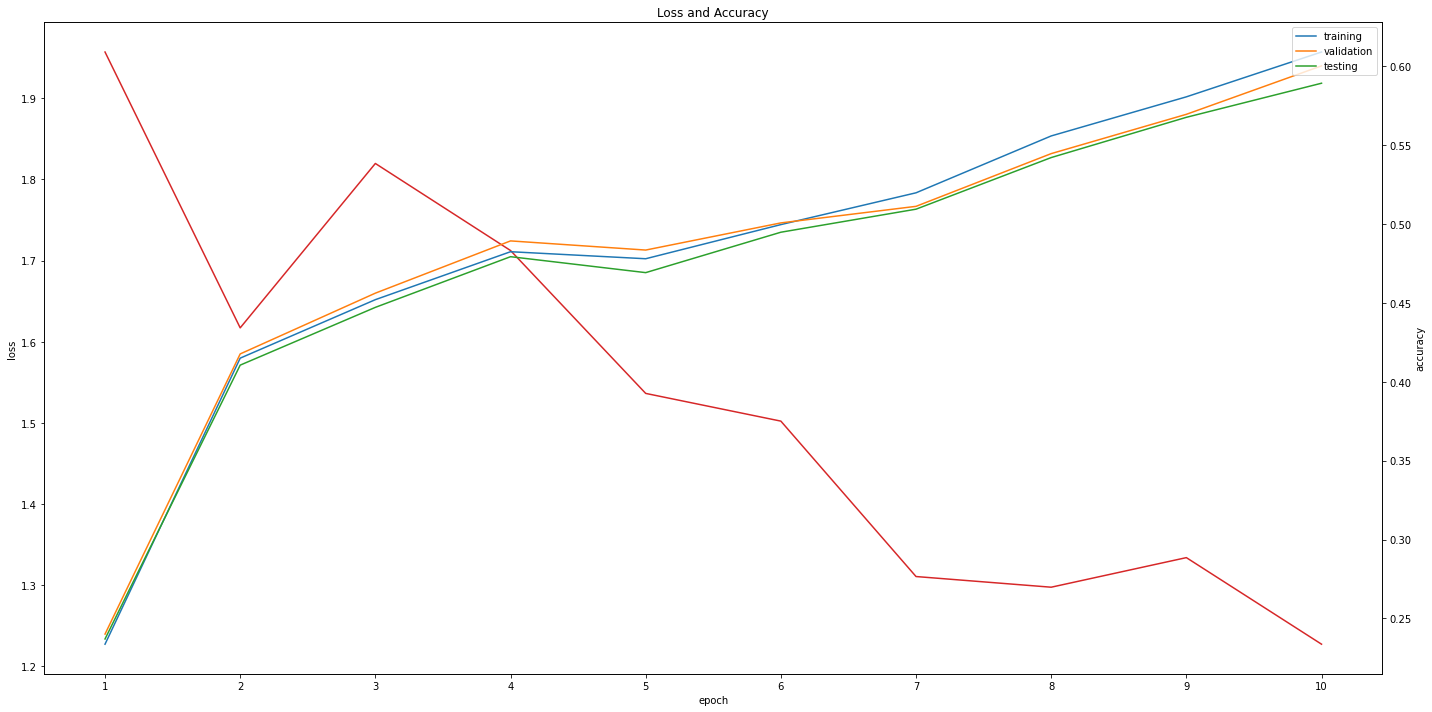

Run 2
--------------------------------------------------------------------------------
Epoch #  1	Current loss: 1.670147	Training Accuracy = 0.577900	Validation Accuracy = 0.566600	Testing Accuracy = 0.558800	
Epoch #  2	Current loss: 1.163191	Training Accuracy = 0.624950	Validation Accuracy = 0.603600	Testing Accuracy = 0.600400	
Epoch #  3	Current loss: 1.287592	Training Accuracy = 0.618750	Validation Accuracy = 0.591600	Testing Accuracy = 0.592200	
Epoch #  4	Current loss: 1.252782	Training Accuracy = 0.602500	Validation Accuracy = 0.579400	Testing Accuracy = 0.583800	
Epoch #  5	Current loss: 1.177295	Training Accuracy = 0.628825	Validation Accuracy = 0.601300	Testing Accuracy = 0.598000	
Epoch #  6	Current loss: 1.355103	Training Accuracy = 0.636700	Validation Accuracy = 0.609800	Testing Accuracy = 0.605400	
Epoch #  7	Current loss: 1.346442	Training Accuracy = 0.624575	Validation Accuracy = 0.593300	Testing Accuracy = 0.596700	
Epoch #  8	Current loss: 1.060851	Training Accuracy 

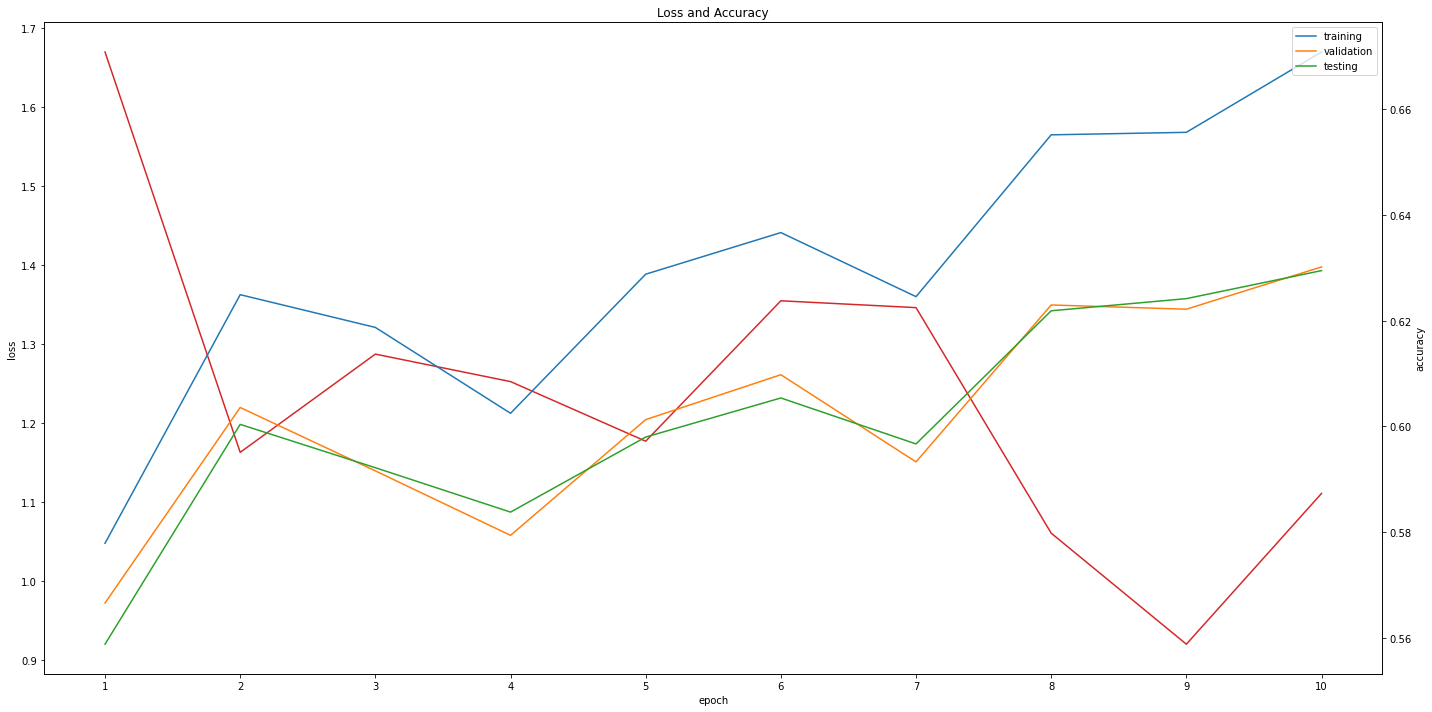

Run 3
--------------------------------------------------------------------------------
Epoch #  1	Current loss: 1.054136	Training Accuracy = 0.649700	Validation Accuracy = 0.646100	Testing Accuracy = 0.621800	
Epoch #  2	Current loss: 0.982491	Training Accuracy = 0.650625	Validation Accuracy = 0.640300	Testing Accuracy = 0.629800	
Epoch #  3	Current loss: 1.289720	Training Accuracy = 0.681475	Validation Accuracy = 0.672100	Testing Accuracy = 0.653300	
Epoch #  4	Current loss: 1.206021	Training Accuracy = 0.684900	Validation Accuracy = 0.667900	Testing Accuracy = 0.651800	
Epoch #  5	Current loss: 1.049249	Training Accuracy = 0.689075	Validation Accuracy = 0.668300	Testing Accuracy = 0.653900	
Epoch #  6	Current loss: 1.209511	Training Accuracy = 0.689075	Validation Accuracy = 0.675900	Testing Accuracy = 0.656900	
Epoch #  7	Current loss: 1.075146	Training Accuracy = 0.692000	Validation Accuracy = 0.676400	Testing Accuracy = 0.652600	
Epoch #  8	Current loss: 1.367923	Training Accuracy 

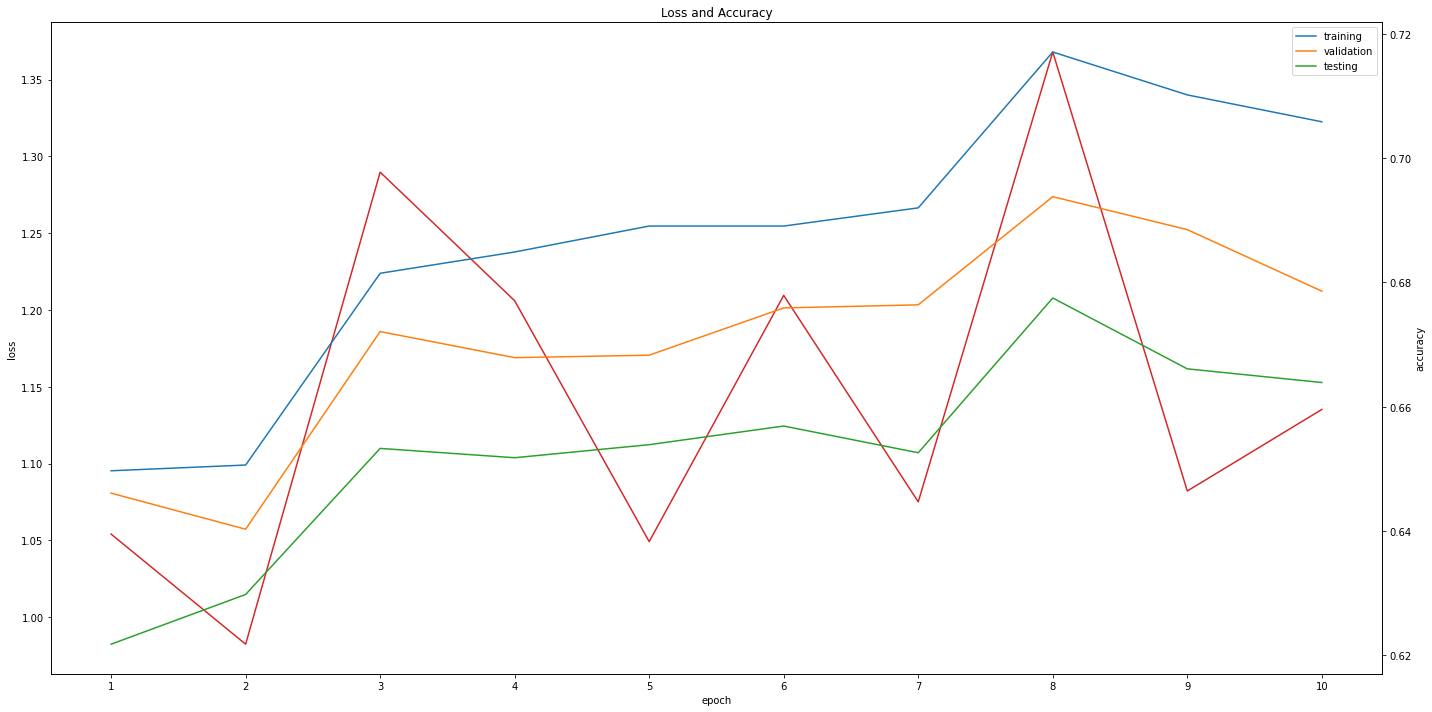

Results
--------------------------------------------------------------------------------
Average Training Accuracy: 0.6618666666666666, Average Validation Accuracy: 0.6363, Average Testing Accuracy: 0.6275


In [ ]:
# run 3 times
print("Run 1")
print("-"*80)
train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test = prepare_dataset()
tr_acc_run_1, va_acc_run_1, te_acc_run_1 = train_and_test(train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test)

print("Run 2")
print("-"*80)
train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test = prepare_dataset()
tr_acc_run_2, va_acc_run_2, te_acc_run_2 = train_and_test(train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test)

print("Run 3")
print("-"*80)
train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test = prepare_dataset()
tr_acc_run_3, va_acc_run_3, te_acc_run_3 = train_and_test(train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test)

print("Results")
print("-"*80)
print("Average Training Accuracy: {}, Average Validation Accuracy: {}, Average Testing Accuracy: {}".format((tr_acc_run_1+tr_acc_run_2+tr_acc_run_3)/3, (va_acc_run_1+va_acc_run_2+va_acc_run_3)/3, (te_acc_run_1+te_acc_run_2+te_acc_run_3)/3))


In [8]:
# load the saved datasets
X_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy")
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy")
X_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy")
y_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy")

# normalize the datasets
X_train = X_train.astype(np.float32) / 255
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32) /255
y_test = y_test.astype(np.float32)

# load the saved model
model_cnn = load_model("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_model_p1.h5")

# obtain the training accuracy
y_pred = model_cnn.predict(X_train)
y_pred_classes = [np.argmax(y_p) for y_p in y_pred]

print("For Training Dataset:")
print("Classification Report: \n", classification_report(y_train, y_pred_classes))
print("Training Accuracy =",accuracy_score(y_train, y_pred_classes))
print("Confusion Matrix =\n",confusion_matrix(y_train, y_pred_classes))

# obtain the testing accuracy
y_pred = model_cnn.predict(X_test)
y_pred_classes = [np.argmax(y_p) for y_p in y_pred]

print("For Testing Dataset:")
print("Classification Report: \n", classification_report(y_test, y_pred_classes))
print("Testing Accuracy =",accuracy_score(y_test, y_pred_classes))
print("Confusion Matrix =\n",confusion_matrix(y_test, y_pred_classes))

For Training Dataset:
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.59      0.70      5000
         1.0       0.91      0.82      0.86      5000
         2.0       0.72      0.49      0.58      5000
         3.0       0.45      0.44      0.45      5000
         4.0       0.61      0.76      0.68      5000
         5.0       0.62      0.52      0.57      5000
         6.0       0.61      0.90      0.73      5000
         7.0       0.87      0.70      0.78      5000
         8.0       0.70      0.94      0.80      5000
         9.0       0.81      0.85      0.83      5000

    accuracy                           0.70     50000
   macro avg       0.72      0.70      0.70     50000
weighted avg       0.72      0.70      0.70     50000

Training Accuracy = 0.7004
Confusion Matrix =
 [[2967   77  356  105  105   18  136   37 1012  187]
 [  29 4077    8   26   12    2  115    3  329  399]
 [ 195   21 2445  380  830  191  715   38

# Part 2

In [3]:
# Author: Xiaopeng Pan
# ID: 1129446
# Purpose: Assignment 2 Part 2
# Date: Mar 8, 2021

# import basic packages
import numpy as np
import matplotlib.pyplot as plt
import os                   # to list the images
import random
import time

# to evaluate the performance
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix

# import keras package to create the CNN model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, \
                                    Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import warnings   # to disable warning
warnings.filterwarnings('ignore')     

## Task 1  
run the pretrained DCNN from Section 2 with the data from Section 1, take the average accuracy from 3 runs (test and training)

In [ ]:
# import Dense